# Gamma Ray Brust

- The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
- You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 
 
 Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 


In [13]:
import requests
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

from sklearn.neighbors import KernelDensity

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names
#print(data.shape)

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
ra = np.array(data[3], dtype=float)
dec = np.array(data[4], dtype=float)
pos_error = np.array(data[5], dtype=float)
T90=np.array(data[6],dtype=float)
T90_error = np.array(data[7], dtype=float)
fluence = np.array(data[9],dtype=float)
fluence_error = np.array(data[10], dtype=float)
redshift = np.array(data[11], dtype=float)
T100 = np.array(data[12], dtype=float)

# T90

Total number of events: 8285
Number of events after "cleaning": 7250


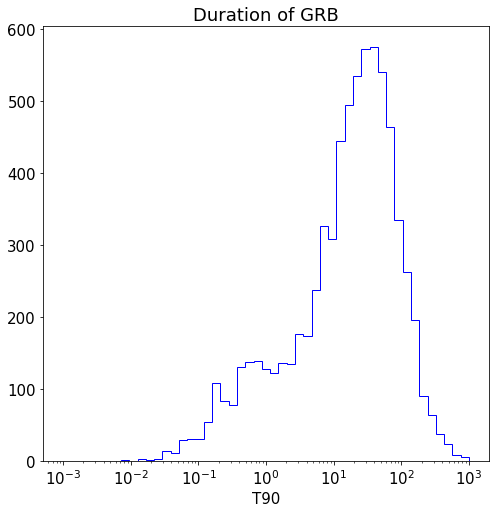

In [5]:
#A little cleaning of the dataset

print('Total number of events:', len(T90))
mask = T90>0
print('Number of events after "cleaning":', len(T90[mask]))

plt.hist(T90[mask], bins=np.logspace(-3, 3, 50), histtype='step', color='b')
plt.semilogx()
plt.xlabel('T90')
plt.title('Duration of GRB')
plt.show()

We want to find if there are present other populations through AIC method and Gaussian Mixture.

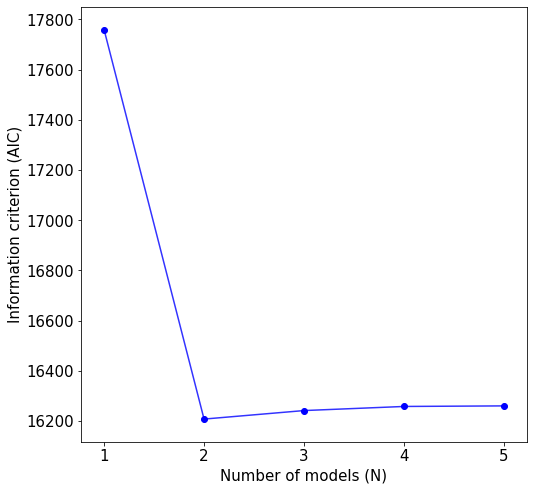

The number of the distributions present in the graph is: 2


In [6]:
t = np.log10(T90[mask])

#reshape of t
t_reshape = np.reshape(t, (-1, 1))

#I define the number of possible models
N = np.linspace(1, 5, 5, dtype=int)
models = np.array([GaussianMixture(n_components=i).fit(t_reshape) for i in N])


#AIC
AIC = np.empty(len(N)) #otherwise the lenght of the AIC is double
for i in range(len(N)):
    AIC[i] = models[i].aic(t_reshape) 
#print(len(N))
#print(len(AIC))

#plot of the number of models
plt.plot(N, AIC, color='b', alpha=0.8)
plt.scatter(N, AIC, color='b')
plt.xlabel('Number of models (N)')
plt.ylabel('Information criterion (AIC)')
plt.xticks(N)
plt.show()

#number of components for best model
minimum = np.argmin(AIC)
best_model = N[minimum]
print('The number of the distributions present in the graph is:', best_model)

The best model is the one with 2 components (two Gaussian distributions). Now we try to show the total gaussian mixture and the two different gaussians that represent the two components.

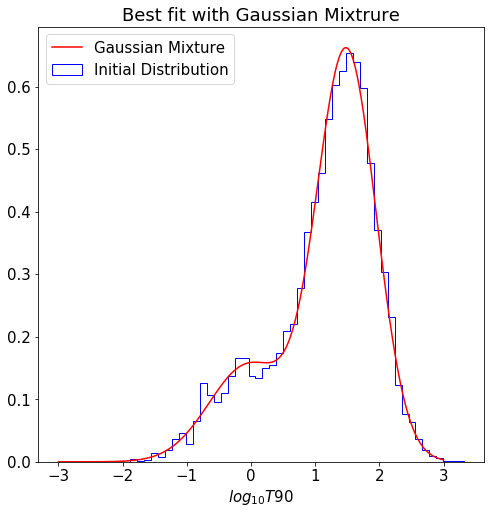

In [7]:
x_grid = np.linspace(-3, 3, 300)

best_model_gm = models[minimum]
#logarithm of the likelihood for each sample
log_p = best_model_gm.score_samples(x_grid[:, np.newaxis])
pdf = np.exp(log_p)


plt.hist(t, bins=50, density=True, histtype='step', color='b', label='Initial Distribution')
plt.plot(x_grid, pdf, color='red', label='Gaussian Mixture')
plt.title('Best fit with Gaussian Mixtrure')
plt.legend()
plt.xlabel(r'$log_{10}T90$')
plt.show()

Now I try to show the different modes with the Gaussians.

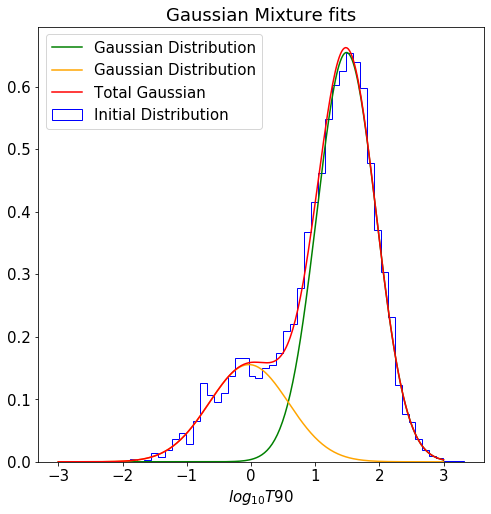

In [8]:
#density of each Gaussian component for each sample
density = best_model_gm.predict_proba(x_grid[:, np.newaxis])
pdf_individ = np.exp(density)
#now I evaluate the sigle pdf for each component
pdf_dens = density*pdf[:, np.newaxis] #np.newaxis perchè altrimenti ho shape differenti

plt.hist(t, bins=50, density=True, histtype='step', color='b', label='Initial Distribution')

#plot each individual pdf
plt.plot(x_grid, pdf_dens[:,0], label='Gaussian Distribution', color='green')
plt.plot(x_grid, pdf_dens[:,1], label='Gaussian Distribution', color='orange')
    
plt.plot(x_grid, pdf, label='Total Gaussian', color='red')
plt.xlabel(r'$log_{10}T90$')
plt.title("Gaussian Mixture fits")
plt.legend()
plt.show()

We can now clearly see the two distributions represeted in the plot with the color yellow and the color green. In red is represented the total gaussian distribution.

# K-Means Clustering

Now I try with K-Means in order to find the threshold between the classes.

In [9]:
cluster = KMeans(n_clusters=2)
cluster.fit(t.reshape(-1,1))

#location of the clusters
km_centers = cluster.cluster_centers_ 
#labels for each point
km_labels = cluster.predict(t.reshape(-1,1))

In [10]:
#swap of the labels
def swap_labels(data, labels, centers):
    if centers[0] > centers[1]:
        centers = centers[::-1]
        for i in range(len(data)):
            if labels[i] == 0:
                labels[i] = 1
            elif labels[1] == 1:
                labels[i] = 0
    return labels, centers     

km_labels, km_centers = swap_labels(t_reshape, km_labels, km_centers)
#actually in this case is not neede because the clusters are already ordered

The threshold is: 0.7413087514783269


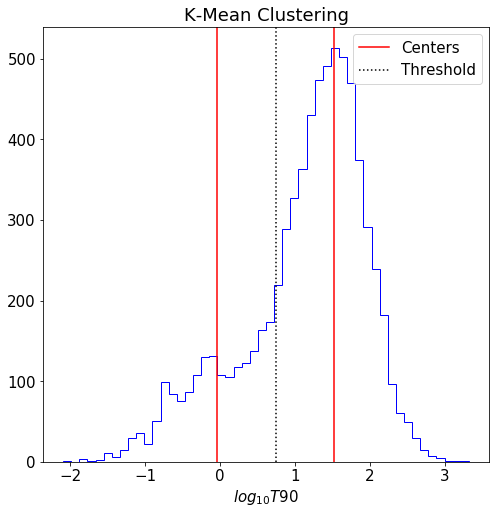

In [11]:
shortGRB = t[km_labels == 0]
longGRB = t[km_labels == 1]

km_threshold = np.mean([max(t[km_labels==0]), min(t[km_labels==1])])
print("The threshold is:", km_threshold)

plt.hist(t, bins=50, histtype='step', color='b')
plt.axvline(km_centers[0], color='red', label='Centers')
plt.axvline(km_centers[1], color='red')
plt.axvline(km_threshold, color='black', linestyle='dotted', label='Threshold')
plt.xlabel(r'$log_{10}T90$')
plt.title('K-Mean Clustering')
plt.legend()
plt.show()

In [12]:
#estimation of the centers
print('The value of the centers are', 10**km_centers[0,0], 's and', 10**km_centers[1,0], 's')

The value of the centers are 0.9073497645764572 s and 33.42483681520108 s


# Mean-Shift Clustering

We also use Mean-Shift Clustering to find the threshold and the values of the centers.

In [24]:
# estimate the bandwidth
bandwidth = estimate_bandwidth(t.reshape(-1,1))
print('The bandwidth is:', bandwidth)

The bandwidth is: 0.5193421745872157


In [25]:
#KDE to see how many modes we have

kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(t_reshape) 

x_grid = np.logspace(-3, 3, 100)
y_grid = np.exp(kde.score_samples(np.log10(x_grid)[:, np.newaxis])) #since we are using a log-likelihood

[]

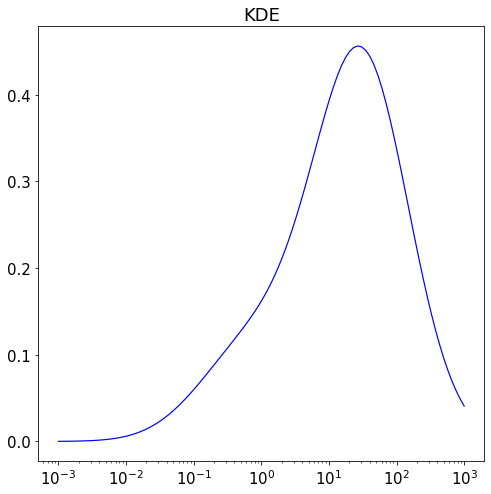

In [26]:
plt.plot(x_grid, y_grid, color='b', lw=1.2)
plt.title('KDE')
plt.semilogx()
plt.plot()

By using the KDE we can not say for sure how many modes we have, so we implemented the Mean Shift and we found the number of clusters.

In [27]:
scaler = preprocessing.StandardScaler()
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True, n_jobs=1)
ms.fit(scaler.fit_transform(t.reshape(-1,1)))

MeanShift(bandwidth=0.5193421745872157, bin_seeding=True, cluster_all=True,
          max_iter=300, min_bin_freq=1, n_jobs=1, seeds=None)

In [28]:
ms_labels = ms.labels_
ms_centers = scaler.inverse_transform(ms.cluster_centers_)

n_clusters = len(np.unique(ms_labels[ms_labels >= 0]))

print('The number of estimated clusters is:', n_clusters)

The number of estimated clusters is: 2


I make sure that the clusters are ordered, by using the same function I used for K-Means.

In [29]:
ms_labels, ms_centers = swap_labels(t, ms_labels, ms_centers)

The threshold is: 0.6126546408629314


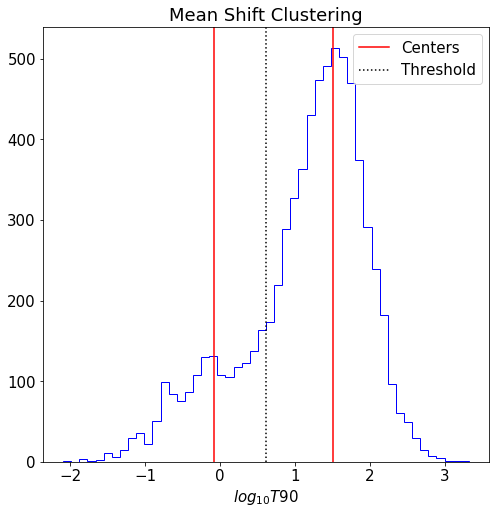

The corrected threshold is: 0.6126546408629314


In [30]:
ms_threshold = np.mean([max(t[ms_labels==1]), min(t[ms_labels==0])])
print("The threshold is:", ms_threshold)

plt.hist(t, bins=50, histtype='step', color='b')
plt.axvline(ms_centers[0], color='red', label='Centers')
plt.axvline(ms_centers[1], color='red')
plt.axvline(ms_threshold, color='black', linestyle='dotted', label='Threshold')
plt.xlabel(r'$log_{10}T90$')
plt.title('Mean Shift Clustering')
plt.legend()
plt.show()

print('The corrected threshold is:', ms_threshold)

In [18]:
#estimation of the centers
print('The value of the centers are', 10**ms_centers[0,0], 's and', 10**ms_centers[1,0], 's')

The value of the centers are 0.8334324688045337 s and 31.513457299892305 s


From the two clustering methods we obtain:
- Two centers;
- Similar threshold;
- Similar centers in seconds.

In [19]:
print('Threshold found with: \n KMeans: ', round(10**km_threshold,1), 's\n Mean-Shift: ', round(10**ms_threshold,1), 
      's')

print('\nCenters of the two groups (Short GRB and Long GRB): \n KMeans:', round(10**km_centers[0,0],1), 's and ', 
      round(10**km_centers[1,0],1), 's\n Mean-Shift: ', round(10**ms_centers[0,0],1), 's and ', 
      round(10**ms_centers[1,0],1), 's')

Threshold found with: 
 KMeans:  5.5 s
 Mean-Shift:  4.1 s

Centers of the two groups (Short GRB and Long GRB): 
 KMeans: 0.9 s and  33.5 s
 Mean-Shift:  0.8 s and  31.5 s


# Fluence

Now I try to show the bimodality with fluence, as for the time I start by showing the bimodality with AIC and Gaussian Mixture, to then showing it with two clustering methods such as: K-Means and Mean Shift.

In [20]:
print('The total number of data is:', len(fluence))
mask_f = fluence > 0
print('The number of data "cleaned" is:', len(fluence[mask]))

The total number of data is: 8269
The number of data "cleaned" is: 7233


In [21]:
f = np.log10(fluence[mask_f])
print(len(f))

7306


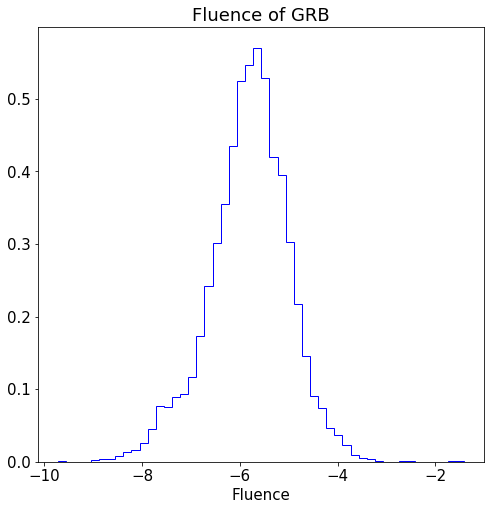

In [22]:
plt.hist(f, bins=50, histtype='step', density=True, color='b')
plt.xlabel('Fluence')
plt.title('Fluence of GRB')
plt.show()

Now I try to show the bimodality, by using K-Means clustering method.

7306
7233
7115 7115


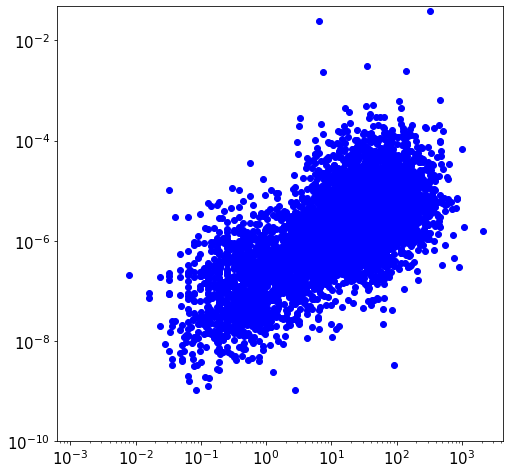

In [23]:
print(len(f))
print(len(t))

#since Fluence and T90 have different lenght we need to do some cleaning
mask_ft = np.logical_and(T90>0, fluence>0)

print(len(T90[mask_ft]), len(fluence[mask_ft]))

plt.scatter(T90[mask_ft], fluence[mask_ft], color='b')
plt.ylim(1e-10)
plt.loglog()
plt.show()

In [24]:
T90_km = np.log10(T90[mask_ft])
fluence_km = np.log10(fluence[mask_ft])

X = np.concatenate([T90_km.reshape(-1,1), fluence_km.reshape(-1,1)], axis=1)
print(X.shape)


clf = KMeans(n_clusters=2)
clf.fit(X)

f_centers = clf.cluster_centers_ #location of the clusters
f_labels = clf.predict(X) #labels for each of the points

(7115, 2)


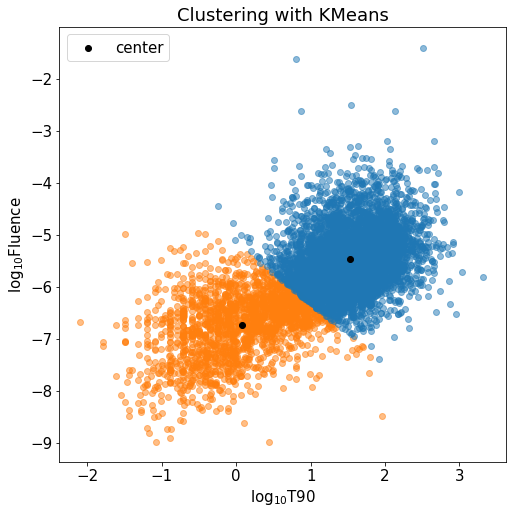

In [25]:
# plot the data color-coded by cluster id
colors = ['C1', 'C0']
for ii in range(2):
    plt.scatter(X[f_labels==ii,0], X[f_labels==ii,1], color=colors[ii],alpha=0.5)

plt.xlabel('log$_{10}$T90')
plt.ylabel('log$_{10}$Fluence')
plt.title('Clustering with KMeans')

plt.scatter(f_centers[0,0], f_centers[0,1], label='center', c='black')
plt.scatter(f_centers[1,0], f_centers[1,1], c='black')

plt.legend()
plt.show()

From the plot is possible to clearly see two centers.

In [26]:
print('The centers of the two clusters are:\n T90 =', round(10**f_centers[0,0],1), 
      's and fluence =', round(10**f_centers[0,1],8), 
      'erg/cm^2 \n T90 =', round(10**f_centers[1,0],1), 
      's and fluence =', round(10**f_centers[1,1],7), 'erg/cm^2')

The centers of the two clusters are:
 T90 = 1.2 s and fluence = 1.9e-07 erg/cm^2 
 T90 = 34.0 s and fluence = 3.4e-06 erg/cm^2


We now try to find the bimodality with Mean-Shift.

In [27]:
f_bandwidth = estimate_bandwidth(X)
print('The bandwidth is:', f_bandwidth)
f_ms = MeanShift(bandwidth=f_bandwidth, bin_seeding=True, cluster_all=True, n_jobs=-1)
f_ms.fit(scaler.fit_transform(X))

The bandwidth is: 0.9188742237283156


MeanShift(bandwidth=0.9188742237283156, bin_seeding=True, cluster_all=True,
          max_iter=300, min_bin_freq=1, n_jobs=-1, seeds=None)

In [28]:
f_ms_labels = np.unique(f_ms.labels_)
print(f_ms_labels)
f_n_clusters = len(f_ms_labels[f_ms_labels >= 0])
print('The clusters are:', f_n_clusters)

[0 1 2 3]
The clusters are: 4


We obtain 4 clusters instead of the 2 expected.

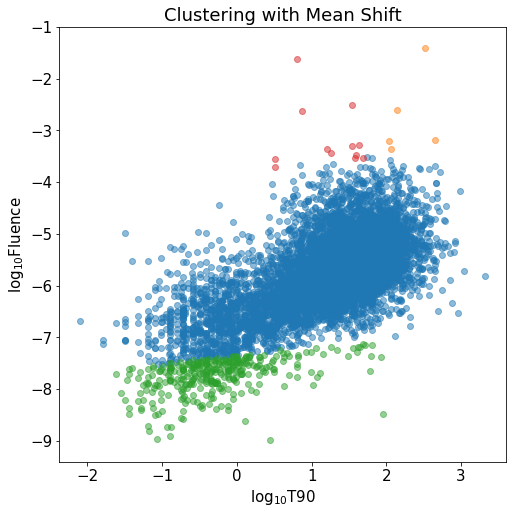

In [29]:
for ii in range(4):
    plt.scatter(X[f_ms.labels_==ii,0], X[f_ms.labels_==ii,1], alpha=0.5)
    
plt.xlabel('log$_{10}$T90')
plt.ylabel('log$_{10}$Fluence')
plt.title('Clustering with Mean Shift')

plt.show()  

This result does not make much sense. Maybe by reducing by hand the bandwidth we will get two expected clusters.

In [30]:
ms_bandwidth = 0.800
new_f_ms = MeanShift(bandwidth=ms_bandwidth, bin_seeding=True, cluster_all=True, n_jobs=-1)
new_f_ms.fit(scaler.fit_transform(X))

f_ms_labels = np.unique(new_f_ms.labels_)
print(f_ms_labels)
f_n_clusters = len(f_ms_labels[f_ms_labels >= 0])
print('The clusters are:', f_n_clusters)

[0 1 2 3 4]
The clusters are: 5


By decreasing the bandwidth we only obtain more clusters, so we try to increase (by hand) the value of the bandwidth.

In [31]:
ms_bandwidth = 1.0
new_f_ms = MeanShift(bandwidth=ms_bandwidth, bin_seeding=True, cluster_all=True, n_jobs=-1)
new_f_ms.fit(scaler.fit_transform(X))

f_ms_labels = np.unique(new_f_ms.labels_)
print(f_ms_labels)
f_n_clusters = len(f_ms_labels[f_ms_labels >= 0])
print('The clusters are:', f_n_clusters)

[0 1 2]
The clusters are: 3


We observe that by increasing the value of the bandwidth we decrease the number of clusters, so we try to increase a little more (always by hand) the value of the bandwidth in order to have the two expected clusters.

In [32]:
ms_bandwidth = 1.5
new_f_ms = MeanShift(bandwidth=ms_bandwidth, bin_seeding=True, cluster_all=True, n_jobs=-1)
new_f_ms.fit(scaler.fit_transform(X))

f_ms_labels = np.unique(new_f_ms.labels_)
print(f_ms_labels)
f_n_clusters = len(f_ms_labels[f_ms_labels >= 0])
print('The clusters are:', f_n_clusters)

[0 1]
The clusters are: 2


We finally obtain two clusters as we expected, we plot them.

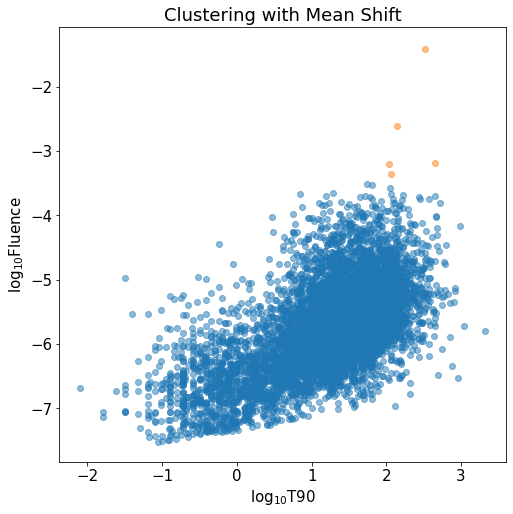

In [33]:
for ii in range(2):
    plt.scatter(X[f_ms.labels_==ii,0], X[f_ms.labels_==ii,1], alpha=0.5)
    
plt.xlabel('log$_{10}$T90')
plt.ylabel('log$_{10}$Fluence')
plt.title('Clustering with Mean Shift')

plt.show()  

By observing the plot we can see that the result does not make much sense. We try another method such as Aikake Information Criterion (AIC) with Gaussian Mixture.

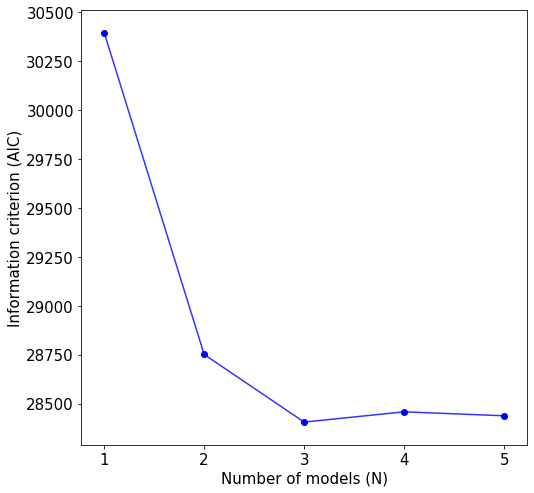

The number of the distributions present in the graph is: 3


In [34]:
#I define the number of possible models
N = np.linspace(1, 5, 5, dtype=int)
models = np.array([GaussianMixture(n_components=i).fit(X) for i in N])


#AIC
AIC = np.empty(len(N)) #otherwise the lenght of the AIC is double
for i in range(len(N)):
    AIC[i] = models[i].aic(X) 
#print(len(N))
#print(len(AIC))

#plot of the number of models
plt.plot(N, AIC, color='b', alpha=0.8)
plt.scatter(N, AIC, color='b')
plt.xlabel('Number of models (N)')
plt.ylabel('Information criterion (AIC)')
plt.xticks(N)
plt.show()

#number of components for best model
minimum = np.argmin(AIC)
best_model_comp = N[minimum]
print('The number of the distributions present in the graph is:', best_model_comp)

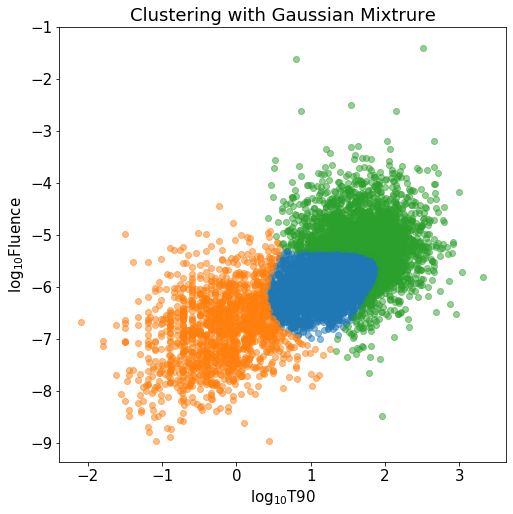

In [35]:
best_model = models[minimum]

gm_labels = best_model.predict(X)

for ii in range(best_model_comp):
    plt.scatter(X[gm_labels==ii,0], X[gm_labels==ii,1], alpha=0.5)

plt.xlabel('log$_{10}$T90')
plt.ylabel('log$_{10}$Fluence')
plt.title('Clustering with Gaussian Mixtrure')

plt.show()      
    

As we can see from the plot we have 3 gaussians predicted by the best model. We can try to force only two Gaussians in order to have the expected 2 clusters.

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)


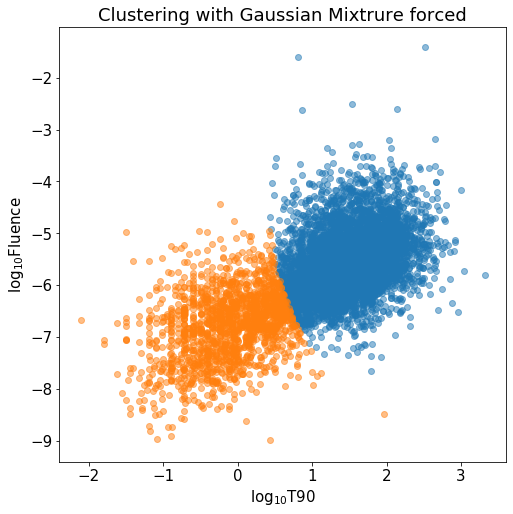

In [36]:
#force 2 Gaussians by hand
gm_2 = models[1]
print(gm_2)

gm_labels_2 = gm_2.predict(X)

for ii in range(2):
        plt.scatter(X[gm_labels_2==ii,0], X[gm_labels_2==ii,1], alpha=0.5)

plt.xlabel('log$_{10}$T90')
plt.ylabel('log$_{10}$Fluence')
plt.title('Clustering with Gaussian Mixtrure forced')

plt.show()    

Finally we obtain only two clusters as we expected. It seems pretty similat to what we obtained with K-Means.

# Redshift

Through redshift we can understand where Long and Short GRB (found when we were studying the duration of GRBs) are found.

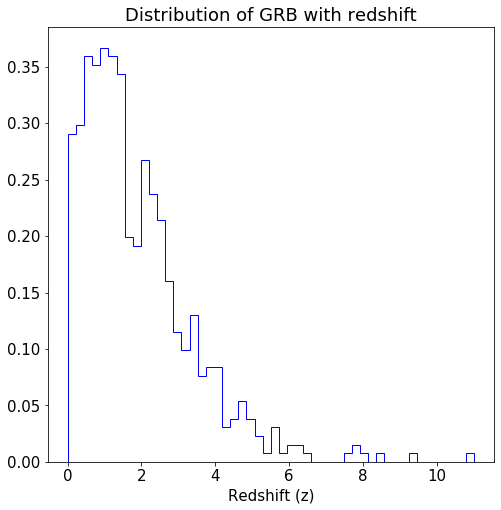

In [37]:
#Rapresentation of the data through redshift

mask_z = redshift > 0
plt.hist(redshift[mask_z], bins=50, density=True, histtype='step', color='b')
plt.xlabel('Redshift (z)')
plt.title('Distribution of GRB with redshift')
plt.show()

0.7413087514783269


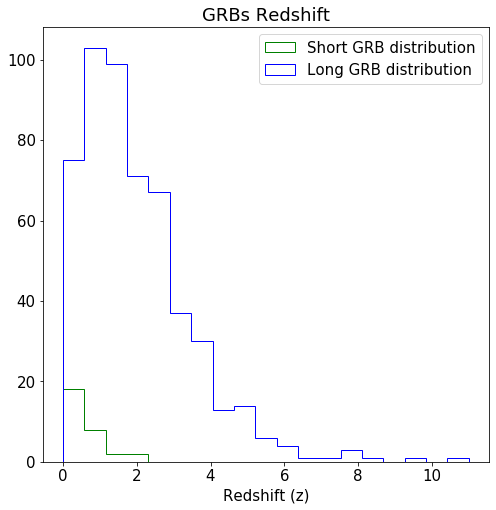

In [38]:
#I use the threshold found with K-Means during the studies on the duration
km_threshold = np.mean([max(t[km_labels==0]), min(t[km_labels==1])])
print(km_threshold)

short_mask = np.logical_and(np.logical_and(T90>0, T90<km_threshold), redshift>0)
long_mask = np.logical_and(T90>km_threshold, redshift>0)

bins = np.linspace(0, 11, 20)

plt.hist(redshift[short_mask], bins=bins, histtype='step', color='green', label='Short GRB distribution')
plt.hist(redshift[long_mask], bins=bins, histtype='step', color='blue', label='Long GRB distribution')
plt.title('GRBs Redshift')
plt.xlabel('Redshift (z)')
plt.legend()
plt.show()

From the plot we can observe that short GRB seems to be close, while long GRB seems to be distant.
But this distribution may be subjected to selection effects. We can also observe their spatial distribution, we know that short and long GRBs tend to be isotropically distributed.

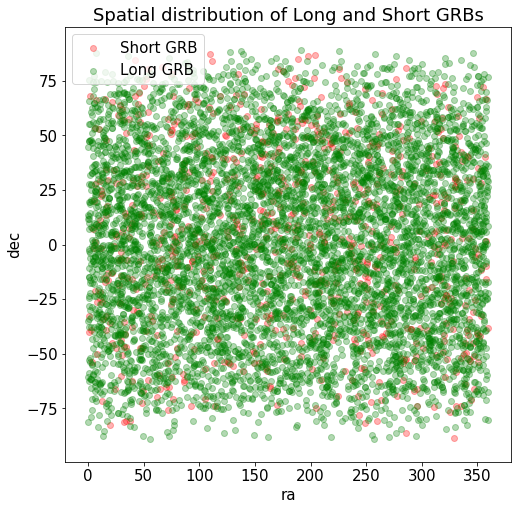

In [39]:
plt.scatter(ra[np.logical_and(T90>0, T90<km_threshold)], dec[np.logical_and(T90>0, T90<km_threshold)], 
           color='red', label='Short GRB', alpha=0.3)
plt.scatter(ra[T90>km_threshold], dec[T90>km_threshold], 
           color='green', label='Long GRB', alpha=0.3)

plt.xlabel('ra')
plt.ylabel('dec')
plt.title('Spatial distribution of Long and Short GRBs')
plt.legend()
plt.show()

We can observe that Long and Short GRBs seem to be isotropically distributed as we expected.

# Errors

Up until now we neglected the errors. Now we take them into considereration.

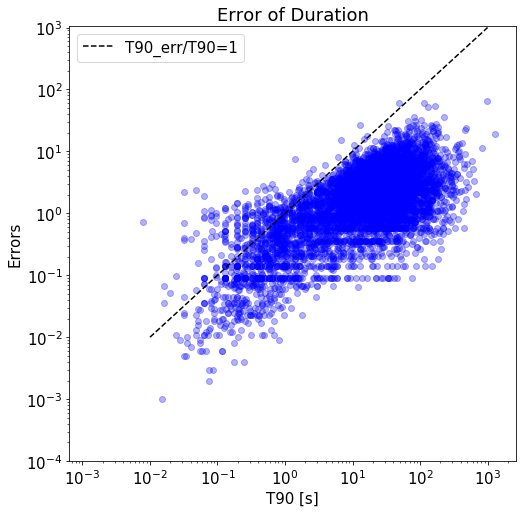

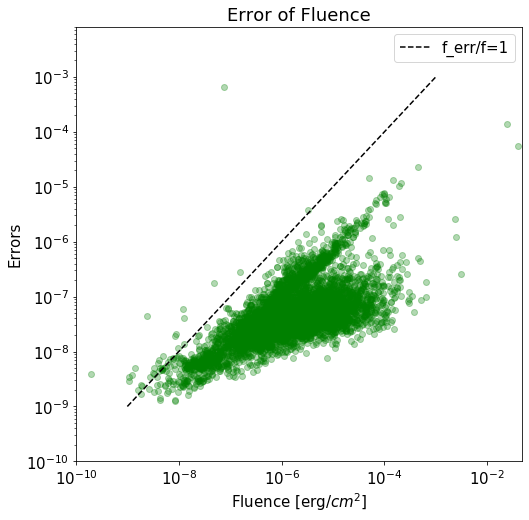

In [40]:
mask_T90_err = np.logical_and(T90>0, T90_error>0)
mask_f_err = np.logical_and(fluence>0, fluence_error>0)

#Duration
plt.scatter(T90[mask_T90_err], T90_error[mask_T90_err], color='b', alpha=0.3)
xgrid = np.logspace(-2, 3, 4)
plt.plot(xgrid, xgrid, color='black', ls='--', label='T90_err/T90=1')
plt.legend()

plt.ylim(1e-4)
plt.loglog()
#plt.semilogx()
#plt.semilogy()
plt.title('Error of Duration')
plt.xlabel('T90 [s]')
plt.ylabel('Errors')
plt.show()

#Fluence
plt.scatter(fluence[mask_f_err], fluence_error[mask_f_err], color='green', alpha=0.3)
xgrid = np.logspace(-9, -3, 4)
plt.plot(xgrid, xgrid, color='black', ls='--', label='f_err/f=1')
plt.legend()

plt.ylim(1e-10)
plt.xlim(1e-10)
plt.loglog()
plt.title('Error of Fluence')
plt.xlabel(r'Fluence [erg/$cm^2$]')
plt.ylabel('Errors')
plt.show()

By observing the two graphs: if we consider the durtaion we have that some events have an error bigger than the signal itself, in particular this happens in the shortest events. Otherwise if we consider the fluence we can say that in general the value of the error is smaller than the value of the signal.